<a href="https://colab.research.google.com/github/saqlineniam/Small-Scale-Drone-Weed-Detection-using-Machine-Vision/blob/main/Weed_masking_system_using_mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Import Required Libraries
import os
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image
import numpy as np
from tqdm import tqdm
from PIL import Image as PILImage, ImageDraw

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cell 2: Define WeedDataset Class with Mask Support (FIXED)

class WeedDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (string): Directory with 'images' and 'annotations' folders
            transforms (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.annotations_dir = os.path.join(root_dir, 'annotations')
        self.transforms = transforms

        # Create class to index mapping
        # Add 'background' as class 0 (required for Mask R-CNN)
        self.class_to_idx = {
            'background': 0,
            'carpetweed': 1,
            'morningglory': 2,
            'palmer_amaranth': 3
        }
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        # Get all JSON annotation files
        self.annotation_files = [f for f in os.listdir(self.annotations_dir)
                                if f.endswith('.json')]

        # Create a mapping of image files to their annotations
        self.samples = []
        for ann_file in self.annotation_files:
            ann_path = os.path.join(self.annotations_dir, ann_file)
            with open(ann_path, 'r') as f:
                data = json.load(f)

            # Extract the actual data (it's nested in a key)
            for key, value in data.items():
                img_filename = value['filename']
                img_path = os.path.join(self.images_dir, img_filename)

                # Only add if image exists
                if os.path.exists(img_path):
                    self.samples.append({
                        'image_path': img_path,
                        'annotation': value
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns:
            image (Tensor): Image tensor
            target (dict): Dictionary containing:
                - boxes (FloatTensor[N, 4]): Bounding boxes in [x_min, y_min, x_max, y_max] format
                - labels (Int64Tensor[N]): Class labels
                - masks (UInt8Tensor[N, H, W]): Segmentation masks
                - image_id (Tensor): Image identifier
                - area (Tensor): Area of each bounding box
                - iscrowd (UInt8Tensor[N]): Whether the box is a crowd (0 for all)
        """
        sample = self.samples[idx]

        # Load image
        img = PILImage.open(sample['image_path']).convert('RGB')
        img_width, img_height = img.size

        # Extract annotations
        annotation = sample['annotation']
        regions = annotation.get('regions', [])

        boxes = []
        labels = []
        masks = []

        for region in regions:
            shape_attrs = region['shape_attributes']
            region_attrs = region['region_attributes']

            # Get class label
            class_name = region_attrs.get('class')

            # Only process if class name is valid
            if class_name and class_name in self.class_to_idx:
                label = self.class_to_idx[class_name]

                # Handle rectangle annotations
                if shape_attrs['name'] == 'rect':
                    x = shape_attrs['x']
                    y = shape_attrs['y']
                    width = shape_attrs['width']
                    height = shape_attrs['height']

                    # Convert to [x_min, y_min, x_max, y_max] format
                    x_min = x
                    y_min = y
                    x_max = x + width
                    y_max = y + height

                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(label)

                    # Create binary mask from bounding box
                    mask = np.zeros((img_height, img_width), dtype=np.uint8)
                    mask[int(y_min):int(y_max), int(x_min):int(x_max)] = 1
                    masks.append(mask)

                # Handle polygon annotations
                elif shape_attrs['name'] == 'polygon':
                    all_points_x = shape_attrs['all_points_x']
                    all_points_y = shape_attrs['all_points_y']

                    # Create bounding box from polygon
                    x_min = min(all_points_x)
                    y_min = min(all_points_y)
                    x_max = max(all_points_x)
                    y_max = max(all_points_y)

                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(label)

                    # Create binary mask from polygon
                    mask_img = PILImage.new('L', (img_width, img_height), 0)
                    draw = ImageDraw.Draw(mask_img)
                    polygon = list(zip(all_points_x, all_points_y))
                    draw.polygon(polygon, outline=1, fill=1)
                    mask = np.array(mask_img, dtype=np.uint8)
                    masks.append(mask)
            else:
                print(f"Warning: Unknown or missing class '{class_name}' in image {idx}, skipping annotation")

        # Handle edge case: if no valid boxes found, create empty tensors
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, img_height, img_width), dtype=torch.uint8)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.uint8)
        else:
            # Convert to tensors
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

            # Calculate area of each box
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            # iscrowd = 0 for all instances (not a crowd)
            iscrowd = torch.zeros((len(boxes),), dtype=torch.uint8)

        # Create image_id tensor
        image_id = torch.tensor([idx])

        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        # Apply transforms if any
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        else:
            # Convert PIL image to tensor
            img = transforms.ToTensor()(img)

        return img, target

    def get_class_name(self, idx):
        """Get class name from index"""
        return self.idx_to_class.get(idx, 'unknown')

    def get_num_classes(self):
        """Get total number of classes (including background)"""
        return len(self.class_to_idx)

    def get_image_path(self, idx):
        """Get the file path of an image"""
        return self.samples[idx]['image_path']

    def split_dataset(self, validation_split=0.3):
        """
        Splits the dataset into training and validation sets.

        Args:
            validation_split (float): Proportion of dataset to use for validation (default is 30%)

        Returns:
            train_dataset, val_dataset: Splitted datasets for training and validation
        """
        dataset_size = len(self)
        val_size = int(dataset_size * validation_split)
        train_size = dataset_size - val_size

        # Generate list of indices
        indices = list(range(dataset_size))
        random.shuffle(indices)

        # Create training and validation indices
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]

        # Create new datasets for train and validation
        train_dataset = WeedDatasetSubset(self, train_indices)
        val_dataset = WeedDatasetSubset(self, val_indices)

        return train_dataset, val_dataset

In [4]:
# Cell 3: Define WeedDatasetSubset Class
class WeedDatasetSubset(Dataset):
    def __init__(self, full_dataset, sample_indices):
        """
        Args:
            full_dataset (WeedDataset): The full dataset instance
            sample_indices (list): List of indices for a subset of the dataset
        """
        self.full_dataset = full_dataset
        self.sample_indices = sample_indices

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        # Get the actual index in the full dataset
        actual_index = self.sample_indices[idx]
        # Return the sample using full_dataset's __getitem__
        return self.full_dataset.__getitem__(actual_index)

In [5]:
# Cell 4: Initialize Dataset
print("Loading dataset...")
dataset = WeedDataset(root_dir=r'/content/drive/MyDrive/CottonWeedDet3')
print(f"Total samples: {len(dataset)}")
print(f"Number of classes: {dataset.get_num_classes()}")

Loading dataset...
Total samples: 848
Number of classes: 4


In [9]:
# Cell 5: Create Mask R-CNN Model
def get_model_instance_segmentation(num_classes):
    # Load pre-trained Mask R-CNN model
    model = maskrcnn_resnet50_fpn(pretrained=True)

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Initialize model
model = get_model_instance_segmentation(dataset.get_num_classes())

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU
model.to(device)

Using device: cuda


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [10]:
# Cell 6: Split Dataset and Create DataLoaders
train_dataset, val_dataset = dataset.split_dataset(validation_split=0.3)
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=0)

Training samples: 594
Validation samples: 254


In [11]:
# Cell 7: Define Optimizer and Learning Rate Scheduler
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [12]:
# Cell 8: Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss_classifier = 0.0
    running_loss_box_reg = 0.0
    running_loss_objectness = 0.0
    running_loss_rpn_box_reg = 0.0
    running_loss_mask = 0.0
    running_total_loss = 0.0

    epoch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True)

    for images, targets in epoch_iterator:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)

        # Track losses
        loss_classifier = loss_dict.get('loss_classifier', torch.tensor(0.0))
        loss_box_reg = loss_dict.get('loss_box_reg', torch.tensor(0.0))
        loss_objectness = loss_dict.get('loss_objectness', torch.tensor(0.0))
        loss_rpn_box_reg = loss_dict.get('loss_rpn_box_reg', torch.tensor(0.0))
        loss_mask = loss_dict.get('loss_mask', torch.tensor(0.0))

        total_loss = sum(loss for loss in loss_dict.values())

        total_loss.backward()
        optimizer.step()

        # Track the loss
        running_loss_classifier += loss_classifier.item()
        running_loss_box_reg += loss_box_reg.item()
        running_loss_objectness += loss_objectness.item()
        running_loss_rpn_box_reg += loss_rpn_box_reg.item()
        running_loss_mask += loss_mask.item()
        running_total_loss += total_loss.item()

        # Update progress bar
        epoch_iterator.set_postfix(
            loss_cls=f"{loss_classifier.item():.4f}",
            loss_box=f"{loss_box_reg.item():.4f}",
            loss_mask=f"{loss_mask.item():.4f}",
            total=f"{total_loss.item():.4f}"
        )

    # Update learning rate
    lr_scheduler.step()

    # Print Epoch Results
    num_batches = len(train_loader)
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"  - Average Loss Classifier: {running_loss_classifier / num_batches:.4f}")
    print(f"  - Average Loss Box Reg: {running_loss_box_reg / num_batches:.4f}")
    print(f"  - Average Loss Objectness: {running_loss_objectness / num_batches:.4f}")
    print(f"  - Average Loss RPN Box Reg: {running_loss_rpn_box_reg / num_batches:.4f}")
    print(f"  - Average Loss Mask: {running_loss_mask / num_batches:.4f}")
    print(f"  - Average Total Loss: {running_total_loss / num_batches:.4f}")
    print(f"  - Learning Rate: {optimizer.param_groups[0]['lr']:.6f}\n")

print("Training completed!")


Epoch 1/10: 100%|██████████| 149/149 [18:42<00:00,  7.54s/it, loss_box=0.1249, loss_cls=0.1295, loss_mask=0.2194, total=0.5646]



Epoch [1/10]
  - Average Loss Classifier: 0.1862
  - Average Loss Box Reg: 0.1776
  - Average Loss Objectness: 0.0137
  - Average Loss RPN Box Reg: 0.0147
  - Average Loss Mask: 0.3161
  - Average Total Loss: 0.7085
  - Learning Rate: 0.005000



Epoch 2/10: 100%|██████████| 149/149 [10:21<00:00,  4.17s/it, loss_box=0.0590, loss_cls=0.0440, loss_mask=0.1383, total=0.2487]



Epoch [2/10]
  - Average Loss Classifier: 0.1302
  - Average Loss Box Reg: 0.1045
  - Average Loss Objectness: 0.0064
  - Average Loss RPN Box Reg: 0.0114
  - Average Loss Mask: 0.2005
  - Average Total Loss: 0.4530
  - Learning Rate: 0.005000



Epoch 3/10: 100%|██████████| 149/149 [10:23<00:00,  4.19s/it, loss_box=0.1037, loss_cls=0.0681, loss_mask=0.1633, total=0.3606]



Epoch [3/10]
  - Average Loss Classifier: 0.0916
  - Average Loss Box Reg: 0.0781
  - Average Loss Objectness: 0.0038
  - Average Loss RPN Box Reg: 0.0104
  - Average Loss Mask: 0.1618
  - Average Total Loss: 0.3456
  - Learning Rate: 0.000500



Epoch 4/10: 100%|██████████| 149/149 [10:21<00:00,  4.17s/it, loss_box=0.1412, loss_cls=0.2009, loss_mask=0.2612, total=0.6651]



Epoch [4/10]
  - Average Loss Classifier: 0.0635
  - Average Loss Box Reg: 0.0555
  - Average Loss Objectness: 0.0027
  - Average Loss RPN Box Reg: 0.0084
  - Average Loss Mask: 0.1304
  - Average Total Loss: 0.2604
  - Learning Rate: 0.000500



Epoch 5/10: 100%|██████████| 149/149 [10:23<00:00,  4.18s/it, loss_box=0.0641, loss_cls=0.0412, loss_mask=0.1899, total=0.3252]



Epoch [5/10]
  - Average Loss Classifier: 0.0558
  - Average Loss Box Reg: 0.0494
  - Average Loss Objectness: 0.0020
  - Average Loss RPN Box Reg: 0.0079
  - Average Loss Mask: 0.1197
  - Average Total Loss: 0.2348
  - Learning Rate: 0.000500



Epoch 6/10: 100%|██████████| 149/149 [10:18<00:00,  4.15s/it, loss_box=0.0232, loss_cls=0.0198, loss_mask=0.0853, total=0.1561]



Epoch [6/10]
  - Average Loss Classifier: 0.0513
  - Average Loss Box Reg: 0.0463
  - Average Loss Objectness: 0.0022
  - Average Loss RPN Box Reg: 0.0079
  - Average Loss Mask: 0.1136
  - Average Total Loss: 0.2212
  - Learning Rate: 0.000050



Epoch 7/10: 100%|██████████| 149/149 [10:18<00:00,  4.15s/it, loss_box=0.0208, loss_cls=0.0426, loss_mask=0.0961, total=0.1619]



Epoch [7/10]
  - Average Loss Classifier: 0.0480
  - Average Loss Box Reg: 0.0438
  - Average Loss Objectness: 0.0021
  - Average Loss RPN Box Reg: 0.0075
  - Average Loss Mask: 0.1117
  - Average Total Loss: 0.2131
  - Learning Rate: 0.000050



Epoch 8/10: 100%|██████████| 149/149 [10:18<00:00,  4.15s/it, loss_box=0.0320, loss_cls=0.0294, loss_mask=0.0941, total=0.1615]



Epoch [8/10]
  - Average Loss Classifier: 0.0473
  - Average Loss Box Reg: 0.0432
  - Average Loss Objectness: 0.0018
  - Average Loss RPN Box Reg: 0.0074
  - Average Loss Mask: 0.1106
  - Average Total Loss: 0.2103
  - Learning Rate: 0.000050



Epoch 9/10: 100%|██████████| 149/149 [10:15<00:00,  4.13s/it, loss_box=0.0308, loss_cls=0.0252, loss_mask=0.0929, total=0.1506]



Epoch [9/10]
  - Average Loss Classifier: 0.0469
  - Average Loss Box Reg: 0.0430
  - Average Loss Objectness: 0.0018
  - Average Loss RPN Box Reg: 0.0075
  - Average Loss Mask: 0.1095
  - Average Total Loss: 0.2087
  - Learning Rate: 0.000005



Epoch 10/10: 100%|██████████| 149/149 [10:20<00:00,  4.16s/it, loss_box=0.0409, loss_cls=0.0309, loss_mask=0.1719, total=0.2528]


Epoch [10/10]
  - Average Loss Classifier: 0.0465
  - Average Loss Box Reg: 0.0426
  - Average Loss Objectness: 0.0017
  - Average Loss RPN Box Reg: 0.0074
  - Average Loss Mask: 0.1100
  - Average Total Loss: 0.2084
  - Learning Rate: 0.000005

Training completed!


In [13]:
# Cell 9: Save the Model
# Save the trained model
torch.save(model.state_dict(), 'mask_rcnn_weed_detection.pth')
print("Model saved as 'mask_rcnn_weed_detection.pth'")

# Cell 10: Validation Function (Optional)
def validate_model(model, val_loader, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validating"):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # For validation, we need to set model to train mode to get losses
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            model.eval()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    return avg_val_loss

# Uncomment to run validation after training
# validate_model(model, val_loader, device)


Model saved as 'mask_rcnn_weed_detection.pth'


In [14]:
# Cell 11: Inference Function
def predict(model, image_path, device, threshold=0.5):
    """
    Perform inference on a single image

    Args:
        model: Trained Mask R-CNN model
        image_path: Path to the image
        device: Device to run inference on
        threshold: Confidence threshold for predictions

    Returns:
        Dictionary with predictions (boxes, labels, scores, masks)
    """
    model.eval()

    # Load image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms.ToTensor()(image).to(device)

    with torch.no_grad():
        prediction = model([image_tensor])[0]

    # Filter predictions by threshold
    keep = prediction['scores'] > threshold

    result = {
        'boxes': prediction['boxes'][keep].cpu().numpy(),
        'labels': prediction['labels'][keep].cpu().numpy(),
        'scores': prediction['scores'][keep].cpu().numpy(),
        'masks': prediction['masks'][keep].cpu().numpy()
    }

    return result, image

In [15]:
# Cell 12: Visualization Function
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_prediction(image, prediction, dataset, threshold=0.5):
    """
    Visualize predictions on an image

    Args:
        image: PIL Image
        prediction: Dictionary with predictions
        dataset: Dataset object (to get class names)
        threshold: Confidence threshold
    """
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    boxes = prediction['boxes']
    labels = prediction['labels']
    scores = prediction['scores']
    masks = prediction['masks']

    # Colors for different classes
    colors = ['red', 'blue', 'green', 'yellow', 'cyan', 'magenta']

    for i in range(len(boxes)):
        if scores[i] > threshold:
            box = boxes[i]
            label = labels[i]
            score = scores[i]
            mask = masks[i, 0]

            # Draw bounding box
            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor=colors[label % len(colors)],
                facecolor='none'
            )
            ax.add_patch(rect)

            # Draw mask
            mask_binary = mask > 0.5
            colored_mask = np.zeros((*mask_binary.shape, 4))
            colored_mask[mask_binary] = [*plt.cm.colors.to_rgba(colors[label % len(colors)])[:3], 0.5]
            ax.imshow(colored_mask)

            # Add label
            class_name = dataset.get_class_name(label)
            ax.text(
                box[0], box[1] - 5,
                f'{class_name}: {score:.2f}',
                bbox=dict(facecolor=colors[label % len(colors)], alpha=0.5),
                fontsize=10, color='white'
            )

    plt.axis('off')
    plt.tight_layout()
    plt.show()



In [ ]:
# Cell 13: Test Inference (Example Usage)
# Load the saved model for inference
model.load_state_dict(torch.load('mask_rcnn_weed_detection.pth'))
model.eval()

Detected 2 instances


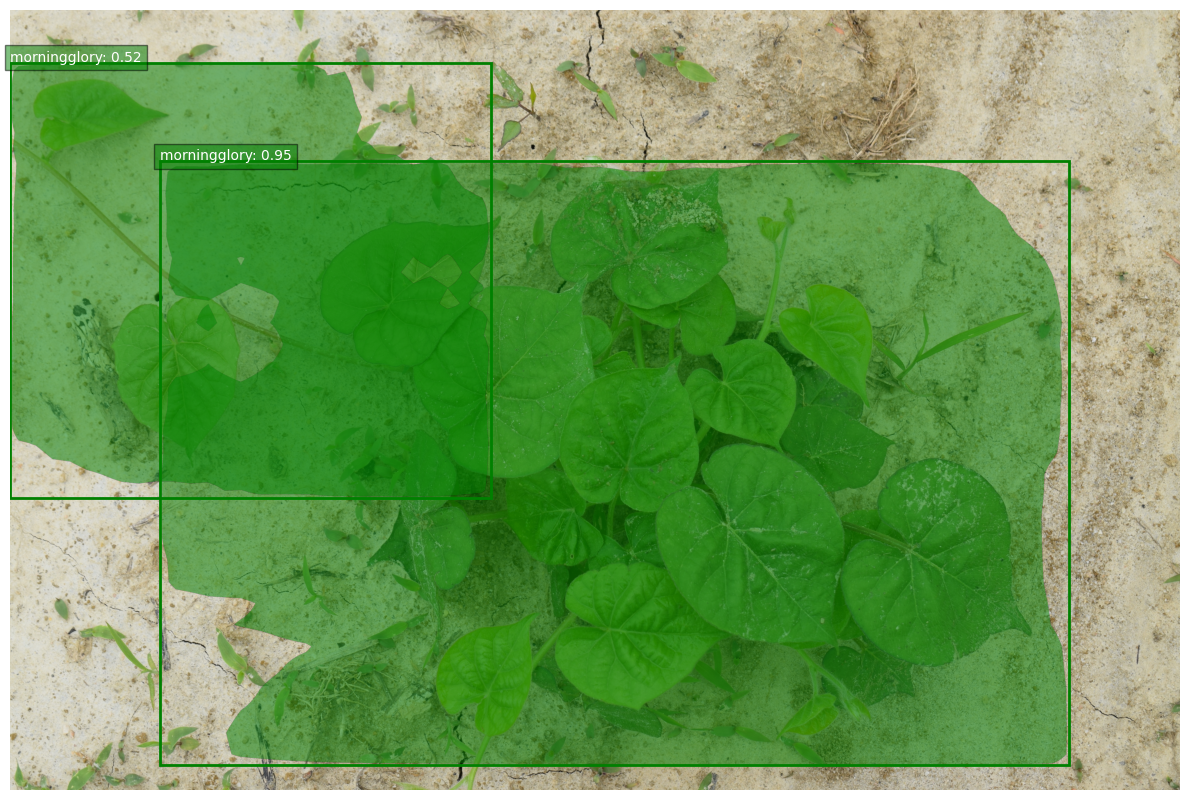

In [30]:

# Get a sample image from validation set
sample_idx = 51
sample_image_path = val_dataset.full_dataset.get_image_path(
    val_dataset.sample_indices[sample_idx]
)

# Run inference
prediction, image = predict(model, sample_image_path, device, threshold=0.5)

# Visualize results
print(f"Detected {len(prediction['boxes'])} instances")
visualize_prediction(image, prediction, dataset, threshold=0.5)